<style>
@page { size: A4; margin: 12mm; }
@media print {
  html, body { -webkit-print-color-adjust: exact; print-color-adjust: exact; }
  /* Evita cortes dentro de bloques */
  .jp-Cell, .jp-Cell-inputWrapper, .jp-Cell-outputWrapper, .jp-OutputArea,
  .jp-RenderedHTMLCommon, .jp-RenderedText, .jp-OutputArea-output,
  pre, code, table, img, p, li, blockquote {
    break-inside: avoid; page-break-inside: avoid; overflow: visible !important;
  }
  /* Envuelve líneas largas (code/outputs) para que no se recorten */
  pre, code, .jp-RenderedHTMLCommon pre, .jp-OutputArea-output pre, .CodeMirror pre {
    white-space: pre-wrap !important;
    word-break: break-word;
    overflow-wrap: anywhere;
  }
  /* Hace que CodeMirror se expanda en alto al imprimir */
  .CodeMirror, .CodeMirror-scroll, .CodeMirror-sizer {
    height: auto !important;
    overflow: visible !important;
  }
  /* Opcional: comenzar secciones grandes en nueva página */
  h1 { page-break-before: always; break-before: page; }
  h1:first-of-type { page-break-before: auto; }
  img { max-width: 100% !important; }
  .jp-Notebook { padding: 0 !important; }
}
</style>

<style>
@page { size: A4; margin: 12mm; }
@media print {
  html, body { -webkit-print-color-adjust: exact; print-color-adjust: exact; }
  /* Evita cortes dentro de bloques */
  .jp-Cell, .jp-Cell-inputWrapper, .jp-Cell-outputWrapper, .jp-OutputArea,
  .jp-RenderedHTMLCommon, .jp-RenderedText, .jp-OutputArea-output,
  pre, code, table, img, p, li, blockquote {
    break-inside: avoid; page-break-inside: avoid; overflow: visible !important;
  }
  /* Envuelve líneas largas (code/outputs) para que no se recorten */
  pre, code, .jp-RenderedHTMLCommon pre, .jp-OutputArea-output pre, .CodeMirror pre {
    white-space: pre-wrap !important;
    word-break: break-word;
    overflow-wrap: anywhere;
  }
  /* Hace que CodeMirror se expanda en alto al imprimir */
  .CodeMirror, .CodeMirror-scroll, .CodeMirror-sizer {
    height: auto !important;
    overflow: visible !important;
  }
  /* Opcional: comenzar secciones grandes en nueva página */
  h1 { page-break-before: always; break-before: page; }
  h1:first-of-type { page-break-before: auto; }
  img { max-width: 100% !important; }
  .jp-Notebook { padding: 0 !important; }
}
</style>

👋 Bienvenido al Organizador de Escapadas IA
Por favor completá los siguientes datos usando SOLO números cuando corresponda:


Seleccioná el medio de transporte:
1. Auto
2. Micro
3. Avión
4. Tren

Seleccioná el nivel de presupuesto:
1. Bajo → Opciones económicas, transporte público, hostels.
2. Medio → Balance entre costo y comodidad.
3. Medio-alto → Hoteles 3-4⭐, experiencias destacadas.
4. Alto → Lujo, experiencias premium.

Seleccioná el modo de viaje:
1. Exprímelo → Aprovechar al máximo cada hora.
2. Relax → Ritmo tranquilo, descansos largos.
3. Cultural → Museos, historia, arquitectura.
4. Gastronómico → Comidas y vinos locales.
5. Aventura → Deportes y excursiones.
6. Familiar → Opciones aptas para todas las edades.

¿Hay niños menores de 12 años en el grupo?
1. Sí
2. No

¿En qué temporada vas a viajar?
1. Alta (vacaciones, feriados largos, temporada turística)
2. Baja (resto del año)

=== Resumen de tu viaje ===
Destino: Bariloche
Medio de transporte: avión
Duración: 7 días, para

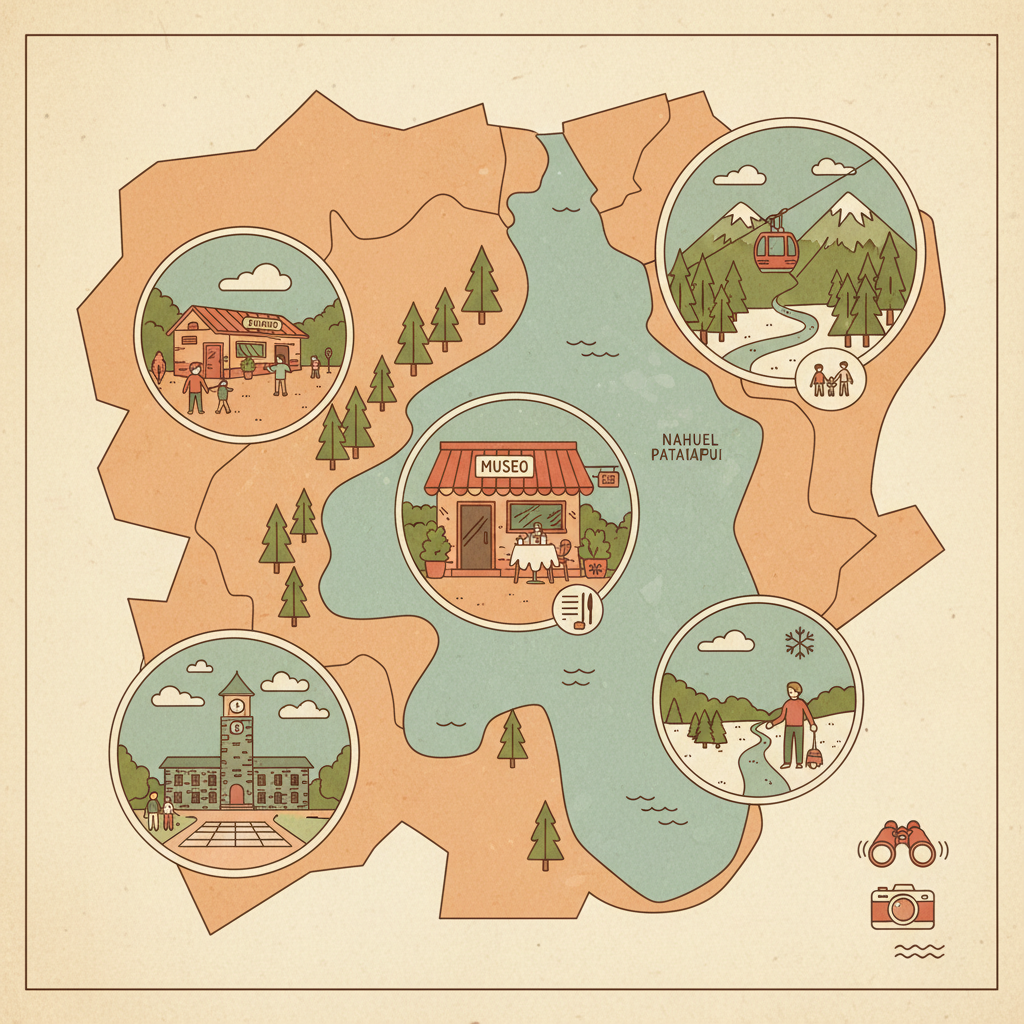

✅ Imagen guardada en bariloche_mapa.png

=== Generando Flyer con Gemini ===


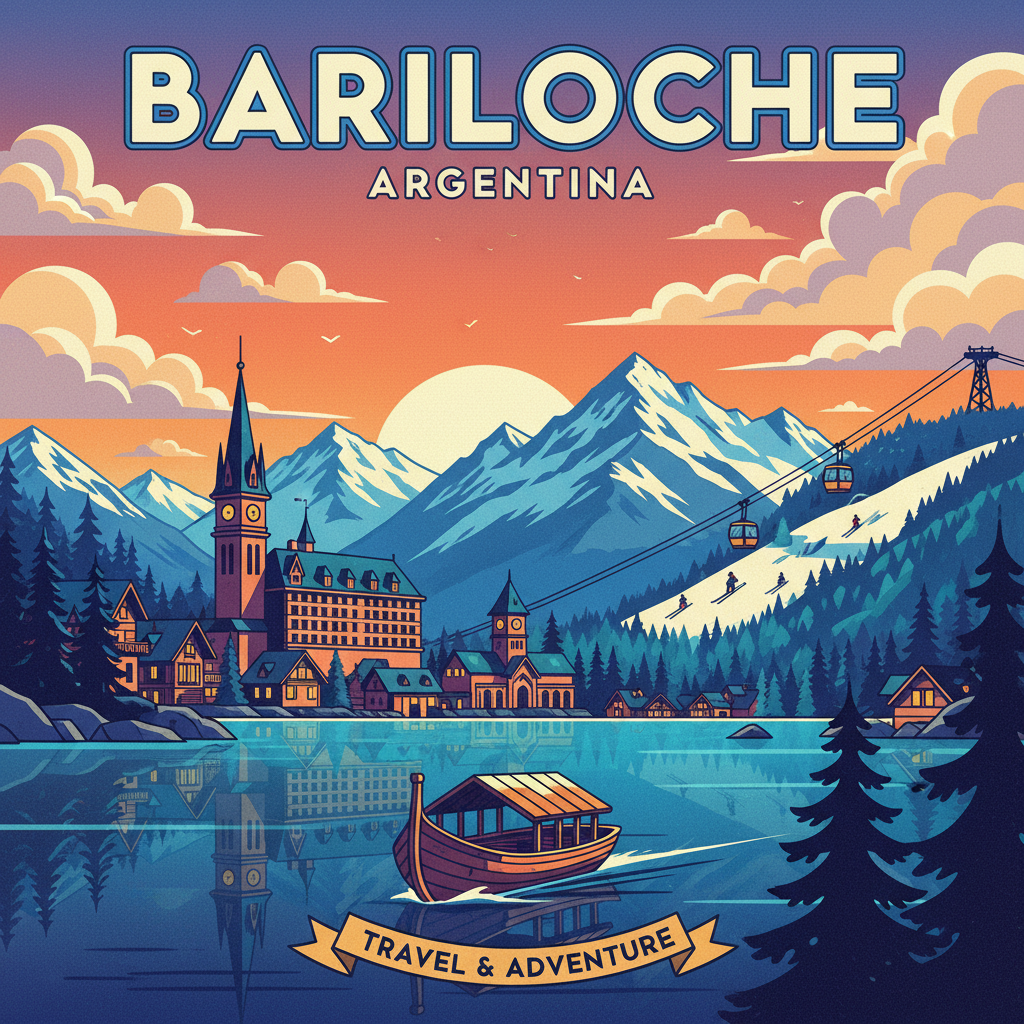

✅ Imagen guardada en bariloche_flyer.png


In [ ]:
# ============================================
# Organizador de Escapadas IA
# SOLO GEMINI (REST) para imágenes + OpenAI para TEXTO
# ============================================

from openai import OpenAI
import os, json, base64, requests
from dotenv import load_dotenv
from datetime import datetime
from PIL import Image
from io import BytesIO
from IPython.display import display

# =======================
# Configuración API
# =======================
load_dotenv()
openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))   # OpenAI para TEXTO
GEMINI_API_KEY = os.getenv("GOOGLE_API_KEY")                  # Gemini para IMAGEN
if not GEMINI_API_KEY:
    raise RuntimeError("Falta GOOGLE_API_KEY en el .env (requerido para imágenes Gemini)")

MODEL_IMG = "gemini-2.5-flash-image-preview"  # según docs oficiales

# =======================
# Variables globales (costos)
# =======================
acumulado_tokens = 0
acumulado_usd = 0.0

# =======================
# Helpers
# =======================
def safe_json_parse(raw_text: str):
    cleaned = raw_text.strip()
    if cleaned.startswith("```"):
        cleaned = cleaned.strip("`")
        cleaned = cleaned.replace("json\n", "").replace("json", "", 1).strip()
    try:
        return json.loads(cleaned)
    except:
        return {}

def calcular_costo(response, nombre="Prompt", archivo="costos_totales.txt"):
    global acumulado_tokens, acumulado_usd
    if not hasattr(response, "usage") or response.usage is None:
        return
    in_tokens = getattr(response.usage, "prompt_tokens", 0)
    out_tokens = getattr(response.usage, "completion_tokens", 0)
    total_tokens = getattr(response.usage, "total_tokens", in_tokens + out_tokens)
    in_price = in_tokens * 0.00000015
    out_price = out_tokens * 0.0000006
    costo_total = in_price + out_price
    acumulado_tokens += total_tokens
    acumulado_usd += costo_total
    with open(archivo, "a", encoding="utf-8") as f:
        f.write(f"{nombre} → Tokens usados: {total_tokens}, USD {costo_total:.6f}\n")

def calcular_costo_imagen(nombre="Imagen", archivo="costos_totales.txt", costo_usd=0.039):
    global acumulado_usd
    acumulado_usd += costo_usd
    with open(archivo, "a", encoding="utf-8") as f:
        f.write(f"{nombre} → Costo imagen: USD {costo_usd:.6f}\n")

def guardar_resumen_tokens(archivo="costos_totales.txt"):
    with open(archivo, "a", encoding="utf-8") as f:
        f.write("\n=== RESUMEN TOTAL ===\n")
        f.write(f"Tokens totales consumidos: {acumulado_tokens}\n")
        f.write(f"Costo total estimado: USD {acumulado_usd:.6f}\n")

# =======================
# Entrada INTERACTIVA
# =======================
def pedir_texto_no_vacio(mensaje: str) -> str:
    while True:
        val = input(mensaje).strip()
        if val:
            return val
        print("⚠️ Ingresá un texto no vacío.")

def pedir_opcion_entera(mensaje: str, opciones_validas: range) -> int:
    while True:
        val = input(mensaje).strip()
        try:
            n = int(val)
            if n in opciones_validas:
                return n
            print(f"⚠️ Opción inválida. Elegí un número en {opciones_validas.start}–{opciones_validas.stop-1}.")
        except ValueError:
            print("⚠️ Ingresá un número entero válido.")

def pedir_entero_min(mensaje: str, minimo: int = 1) -> int:
    while True:
        val = input(mensaje).strip()
        try:
            n = int(val)
            if n >= minimo:
                return n
            print(f"⚠️ Ingresá un entero mayor o igual a {minimo}.")
        except ValueError:
            print("⚠️ Ingresá un número entero válido.")

def pedir_fecha_ddmmyyyy(mensaje: str) -> str:
    while True:
        s = input(mensaje).strip()
        try:
            datetime.strptime(s, "%d/%m/%Y")
            return s
        except ValueError:
            print("⚠️ Fecha inválida. Formato esperado: DD/MM/YYYY.")

def pedir_hora_hhmm(mensaje: str) -> str:
    while True:
        s = input(mensaje).strip()
        if len(s) == 4 and s.isdigit():
            hh = int(s[:2]); mm = int(s[2:])
            if 0 <= hh <= 23 and 0 <= mm <= 59:
                return f"{hh:02d}:{mm:02d}"
        print("⚠️ Hora inválida. Ingresá 4 dígitos HHMM (ej: 0830).")

# =======================
# UI
# =======================
print("👋 Bienvenido al Organizador de Escapadas IA")
print("Por favor completá los siguientes datos usando SOLO números cuando corresponda:\n")

destino = pedir_texto_no_vacio("Destino del viaje (texto libre): ")

print("\nSeleccioná el medio de transporte:")
transportes = {1: "auto", 2: "micro", 3: "avión", 4: "tren"}
for k, v in transportes.items(): print(f"{k}. {v.capitalize()}")
transporte_op = pedir_opcion_entera("Seleccione Medio de Transporte: ", range(1, 5))
transporte = transportes.get(transporte_op, "auto")

cant_personas = pedir_entero_min("\nCantidad de personas: ", minimo=1)

while True:
    fecha_inicio = pedir_fecha_ddmmyyyy("\nFecha de inicio (ej: 15/09/2025): ")
    hora_llegada = pedir_hora_hhmm("Hora de llegada (HHMM, ej: 1000): ")
    fecha_regreso = pedir_fecha_ddmmyyyy("\nFecha de regreso (ej: 21/09/2025): ")
    hora_regreso = pedir_hora_hhmm("Hora de regreso (HHMM, ej: 2200): ")
    try:
        dt_inicio = datetime.strptime(f"{fecha_inicio} {hora_llegada}", "%d/%m/%Y %H:%M")
        dt_regreso = datetime.strptime(f"{fecha_regreso} {hora_regreso}", "%d/%m/%Y %H:%M")
        if dt_regreso <= dt_inicio:
            print("⚠️ La fecha/hora de regreso debe ser posterior a la de inicio. Intentá nuevamente.")
            continue
        break
    except ValueError:
        print("⚠️ Fecha u hora inválida. Intentá nuevamente.")

cant_dias = (dt_regreso.date() - dt_inicio.date()).days + 1
if cant_dias < 1:
    raise ValueError("⚠️ La fecha de regreso debe ser posterior a la fecha de inicio.")

print("\nSeleccioná el nivel de presupuesto:")
presupuestos = {1: "bajo", 2: "medio", 3: "medio-alto", 4: "alto"}
print("1. Bajo → Opciones económicas, transporte público, hostels.")
print("2. Medio → Balance entre costo y comodidad.")
print("3. Medio-alto → Hoteles 3-4⭐, experiencias destacadas.")
print("4. Alto → Lujo, experiencias premium.")
presupuesto_op = pedir_opcion_entera("Seleccione el Nivel de Presupuesto: ", range(1, 5))
presupuesto = presupuestos.get(presupuesto_op, "medio")

print("\nSeleccioná el modo de viaje:")
modos = {
    1: ("Exprímelo", "Aprovechar al máximo cada hora."),
    2: ("Relax", "Ritmo tranquilo, descansos largos."),
    3: ("Cultural", "Museos, historia, arquitectura."),
    4: ("Gastronómico", "Comidas y vinos locales."),
    5: ("Aventura", "Deportes y excursiones."),
    6: ("Familiar", "Opciones aptas para todas las edades.")
}
for k, v in modos.items(): print(f"{k}. {v[0]} → {v[1]}")
modo_op = pedir_opcion_entera("Seleccione el Modo de Viaje: ", range(1, 7))
modo_viaje = modos.get(modo_op, modos[1])[0]

ninos_menores_12 = False
if modo_viaje == "Familiar":
    print("\n¿Hay niños menores de 12 años en el grupo?\n1. Sí\n2. No")
    resp = pedir_opcion_entera("¿Hay niños menores de 12 años en el grupo?: ", range(1, 3))
    ninos_menores_12 = True if resp == 1 else False

print("\n¿En qué temporada vas a viajar?\n1. Alta (vacaciones, feriados largos, temporada turística)\n2. Baja (resto del año)")
temp_op = pedir_opcion_entera("¿En qué temporada vas a viajar?: ", range(1, 3))
temporada = "alta" if temp_op == 1 else "baja"

print("\n=== Resumen de tu viaje ===")
print(f"Destino: {destino}")
print(f"Medio de transporte: {transporte}")
print(f"Duración: {cant_dias} días, para {cant_personas} personas.")
print(f"Llegada: {fecha_inicio} a las {hora_llegada}")
print(f"Regreso: {fecha_regreso} a las {hora_regreso}")
print(f"Presupuesto estimado: {presupuesto}")
print(f"Modo de viaje seleccionado: {modo_viaje}")
if modo_viaje == "Familiar":
    print(f"¿Viajan niños menores de 12 años?: {'Sí' if ninos_menores_12 else 'No'}")
print(f"Temporada: {temporada.upper()}")

# =======================
# Prompt A — Intake JSON (OpenAI TEXTO)
# =======================
intake_prompt = f"""
Sos un organizador de viajes.
Devolvé SOLO un JSON válido.

JSON esperado:
{{
  "param": {{
    "dest": "{destino}",
    "transporte": "{transporte}",
    "dias": {cant_dias},
    "pers": {cant_personas},
    "presupuesto": "{presupuesto}",
    "modo": "{modo_viaje}",
    "fecha_inicio": "{fecha_inicio}",
    "hora_llegada": "{hora_llegada}",
    "fecha_regreso": "{fecha_regreso}",
    "hora_regreso": "{hora_regreso}",
    "ninos_menores_12": {str(ninos_menores_12).lower()},
    "temporada": "{temporada}"
  }}
}}
"""
intake_response = openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "Respondé SOLO con JSON válido y breve."},
        {"role": "user", "content": intake_prompt}
    ],
    temperature=0.2
)
calcular_costo(intake_response, "Prompt A - Intake")
raw_intake = intake_response.choices[0].message.content
intake_json = safe_json_parse(raw_intake)
print("\n=== Intake JSON ===")
print(json.dumps(intake_json, indent=2, ensure_ascii=False))

# =======================
# Prompt A — Itinerario (OpenAI TEXTO)
# =======================
itinerario_prompt = f"""
Usá este JSON:

{json.dumps(intake_json, indent=2, ensure_ascii=False)}

Generá un itinerario detallado de {cant_dias} días para {destino}.

Formato:
Día N - Zona
09:00-11:00 Actividad
[Si corresponde: (traslado: XX min medio)]
11:15-13:00 Actividad
[Si corresponde: (traslado: XX min medio)]
13:15-14:30 Almuerzo (2 opciones)
[Si corresponde: (traslado: XX min medio)]
15:00-17:00 Actividad
[Si corresponde: (traslado: XX min medio)]
17:15-19:00 Actividad
20:00 Cena (2 opciones)

Reglas:
- Todas las actividades, lugares y atracciones deben estar ubicados principalmente dentro del destino {destino} y su área de influencia inmediata. Solo se permiten sugerencias de ciudades o regiones cercanas si están a una distancia razonable para una excursión de un día (aprox. 100–150 km o menos de 2 horas de viaje).
No incluyas propuestas que requieran grandes traslados fuera de la provincia/país, salvo en destinos de frontera donde sea natural cruzar (ejemplo: Cataratas del Iguazú → Brasil, Mendoza → cordillera de Chile).
Si no hay suficientes opciones locales, ampliá la variedad dentro del mismo destino en lugar de traer actividades de regiones lejanas.
- Mostrá tiempos de traslado SOLO cuando cambie el lugar de la actividad.
- No repitas traslado si la siguiente actividad ocurre en el mismo sitio.
- Si el modo de viaje es "Familiar" y hay niños menores de 12 años:
  - Incluí actividades adaptadas y marcá con 👶.
  - Si alguna actividad no es apta para menores o es muy exigente, marcala con ⚠️ y proponé una "Actividad alternativa" en ese mismo día y horario.
- Considerá la temporada:
  - Si es ALTA → recomendá reservas anticipadas, horarios tempranos y opciones alternativas por alta demanda.
  - Si es BAJA → advertí sobre posibles cierres o menor disponibilidad de actividades.
- Al final de cada día, incluir un breve resumen con tips.
"""
itinerario_response = openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "Devolvé solo itinerario en texto limpio."},
        {"role": "user", "content": itinerario_prompt}
    ],
    temperature=0.4
)
calcular_costo(itinerario_response, "Prompt A - Itinerario")
itinerario = itinerario_response.choices[0].message.content
print("\n=== Itinerario generado ===")
print(itinerario)
with open("itinerario_final.txt", "w", encoding="utf-8") as f:
    f.write(itinerario)

# =======================
# Prompt QA — Auditoría (OpenAI TEXTO)
# =======================
qa_prompt = f"""
Revisá el siguiente itinerario y generá un JSON con advertencias relevantes agrupadas por día.

Itinerario:
{itinerario}

Devolvé SOLO un JSON con este formato:
{{
  "alertas": {{
    "Día 2": [
      "Actividad X puede no ser apta para niños",
      "Traslado mayor a 60 minutos"
    ],
    "Día 5": [
      "Actividad Y puede ser excesiva"
    ]
  }}
}}

Reglas:
- Agrupá todas las advertencias bajo el día correspondiente.
- Marcá traslados mayores a 60 minutos.
- Detectá jornadas con exceso de actividades según el modo elegido.
- Señalá actividades no aptas para niños si hay menores de 12 años.
- Si la temporada es "alta" → incluir advertencia de "Reserva anticipada".
- Si la temporada es "baja" → incluir advertencia de "Atracciones cerradas por estacionalidad".
- No incluyas advertencias de temporada que no correspondan.
- Si no hay alertas para un día, no incluyas ese día en el JSON.
"""
qa_response = openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "Actuá como auditor de itinerarios. Respondé SOLO con JSON válido."},
        {"role": "user", "content": qa_prompt}
    ],
    temperature=0.2
)
calcular_costo(qa_response, "Prompt QA - Auditoría")
qa_json = safe_json_parse(qa_response.choices[0].message.content)
print("\n=== QA del itinerario ===")
for dia, alertas in qa_json.get("alertas", {}).items():
    print(f"\n📅 {dia}")
    print("-" * (len(dia) + 4))
    for alerta in alertas:
        icono = "⚠️"
        if "niños" in alerta.lower(): icono = "👶"
        elif "traslado" in alerta.lower(): icono = "🕒"
        elif "reserva" in alerta.lower() or "temporada" in alerta.lower(): icono = "📅"
        print(f"{icono} {alerta}")
    print("-" * 40)

# =======================
# Extracción de lugares (desde el itinerario)
# =======================
lugares = []
palabras_clave = [
    "hotel","restaurante","bodega","actividad","excursión","remis","taxi",
    "auto de alquiler","transfer","museo","café","bar","parque","mercado",
    "zoológico","plaza","mirador","sendero","playa","río","laguna","reserva","centro"
]
for line in itinerario.splitlines():
    texto = line.strip()
    if not texto:
        continue
    if any(palabra in texto.lower() for palabra in palabras_clave):
        lugares.append(texto)
    elif any(w.istitle() for w in texto.split()):
        lugares.append(texto)

print("\n=== Lugares y servicios detectados en el itinerario ===")
print(lugares)
with open("lugares.json", "w", encoding="utf-8") as f:
    json.dump(lugares, f, indent=2, ensure_ascii=False)

# =======================
# Contactos simulados (OpenAI TEXTO)
# =======================
prompt_contactos = f"""
A partir de esta lista de lugares:

{json.dumps(lugares, indent=2, ensure_ascii=False)}

Simulá datos de contacto realistas.

Devolvé SOLO un JSON con:
[
  {{
    "nombre": "...",
    "tipo": "hotel | restaurante | bodega | actividad | excursión | transporte | museo | parque | café",
    "web": "...",
    "telefono": "...",
    "email": "..."
  }}
]
"""
contactos_response = openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "Respondé SOLO con JSON válido."},
        {"role": "user", "content": prompt_contactos}
    ],
    temperature=0.4
)
calcular_costo(contactos_response, "Prompt C - Contactos")
contactos_json = safe_json_parse(contactos_response.choices[0].message.content)
with open("contactos.json", "w", encoding="utf-8") as f:
    json.dump(contactos_json, f, indent=2, ensure_ascii=False)
print("\n=== Lugares y servicios con datos de contacto simulados ===")
for lugar in contactos_json:
    try:
        print(f"📍 {lugar['nombre']} ({lugar['tipo']})")
        print(f"   🌐 Web: {lugar['web']}")
        print(f"   📞 Tel: {lugar['telefono']}")
        print(f"   ✉️  Email: {lugar['email']}")
        print("-" * 50)
    except KeyError:
        print(lugar); print("-" * 50)

# =======================
# Preparar puntos claves → prompt imágenes
# =======================
puntos = []
for line in itinerario.splitlines():
    if any(k in line.lower() for k in ["actividad","almuerzo","cena","tour","visita","excursión","paseo","mirador","sendero","reserva","playa","ballena","pingüino","ave"]):
        puntos.append(line.strip())
puntos_unicos = []
for p in puntos:
    if p not in puntos_unicos:
        puntos_unicos.append(p)
lista_puntos = " | ".join(puntos_unicos[:8])  # limitar para estabilidad del prompt

prompts_img = {
    "Mapa": f"""
Crear una ilustración 16:9 tipo mapa turístico vintage de {destino}, basada en el itinerario.
Paleta cálida (beige, terracota, verdes suaves), textura de papel envejecido.
Contorno simple/esquema del área y 4–6 mini-escenas derivadas de:
{lista_puntos}
Ilustración limpia, sin texto ni marcas de agua. Exportar PNG.
""",
    "Flyer": f"""
Crear un póster 16:9 estilo travel-poster de {destino}.
Motivos icónicos del lugar {destino}.
Exportar PNG.
Colores vibrantes y contraste claro. Sin marcas de agua.
"""
}

# =======================
# Gemini REST — extracción robusta de base64
# =======================
def _extraer_b64_de_respuesta(data: dict) -> str:
    """
    Estructura oficial: candidates[0].content.parts[].inline_data.data (base64)
    + Fallbacks por cambios menores de esquema.
    """
    try:
        for cand in data.get("candidates", []):
            content = cand.get("content", {})
            for part in content.get("parts", []):
                inline = part.get("inline_data") or part.get("inlineData")
                if isinstance(inline, dict) and "data" in inline:
                    return inline["data"]
            # Fallbacks poco comunes:
            if "image" in cand and isinstance(cand["image"], dict) and "bytesBase64" in cand["image"]:
                return cand["image"]["bytesBase64"]
            for m in cand.get("media", []):
                if isinstance(m, dict):
                    if "data" in m: return m["data"]
                    if "bytesBase64" in m: return m["bytesBase64"]
    except Exception:
        pass
    return ""

# =======================
# Generación de imágenes — GEMINI vía REST (CORRECTO)
# =======================
def generar_imagen_gemini(prompt: str, nombre_salida: str):
    url = f"https://generativelanguage.googleapis.com/v1beta/models/{MODEL_IMG}:generateContent"
    headers = {"x-goog-api-key": GEMINI_API_KEY, "Content-Type": "application/json"}
    body = {
        "contents": [{
            "parts": [{"text": prompt}]
        }]
    }
    r = requests.post(url, headers=headers, json=body, timeout=120)
    r.raise_for_status()
    data = r.json()

    b64_img = _extraer_b64_de_respuesta(data)
    if not b64_img:
        print("⚠️ Respuesta de Gemini sin imagen detectable. Claves:", list(data.keys()))
        print(data)
        return

    img_bytes = base64.b64decode(b64_img)
    with open(nombre_salida, "wb") as f:
        f.write(img_bytes)
    img = Image.open(BytesIO(img_bytes))
    display(img)
    print(f"✅ Imagen guardada en {nombre_salida}")
    calcular_costo_imagen(f"Imagen {nombre_salida} (Gemini)", costo_usd=0.00)

# =======================
# Generar imágenes (SOLO GEMINI REST)
# =======================
print("\n=== Generando Mapa con Gemini ===")
generar_imagen_gemini(prompts_img["Mapa"], f"{destino.replace(' ','_').lower()}_mapa.png")

print("\n=== Generando Flyer con Gemini ===")
generar_imagen_gemini(prompts_img["Flyer"], f"{destino.replace(' ','_').lower()}_flyer.png")

# =======================
# Guardar resumen total de tokens
# =======================
guardar_resumen_tokens()
